# 带线性约束的优化
By ZincCat

$\min _{\mathbf{x}} f(\mathbf{x})=\log \left(\sum_{i=1}^{n} e^{x_{i}}\right), \quad$ s.t. $\mathbf{A} \mathbf{x}=\mathbf{b}$

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

In [2]:
p = 100
n = 500

In [3]:
np.random.seed(19890817)
A = np.random.normal(10, 5, (p, n))
b = np.random.normal(10, 5, p)

def P(x, A):
    # return projection matrix of A's product with x
    return x - A.T@np.linalg.inv(A@A.T)@A@x
def projection(x, A, b):
    # return projection of x on Ax=b
    return P(x, A) + A.T@np.linalg.inv(A@A.T)@b
def linesearch_Armijo(f, x, g, d, alpha=0.4, beta=0.8):
    # backtrack linesearch using Armijo rules
    t = 10.0
    value = f(x)
    while f(x + t*d) > value + alpha*t*np.dot(g, d):
        t *= beta
    return t

In [4]:
def f(x):
    return np.max(x) + np.log(np.sum(np.exp(x-np.max(x))))
def grad(x):
    return np.exp(x-np.max(x))/np.sum(np.exp(x-np.max(x)))
def hess(x):
    g = grad(x)
    return -np.outer(g, g) + np.diag(g)
cons = ({'type': 'eq', 'fun': lambda x: A.dot(x)-b})

In [5]:
x0 = projection(10*np.random.rand(n), A, b) # 满足约束的初值

In [6]:
# 调用scipy求值
from scipy.optimize import minimize
res = minimize(f, x0, constraints=cons, tol=1e-10, options={'maxiter': 1e3, 'disp': True})
minValue = res.fun
print("Scipy result:", res.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.215783236005027
            Iterations: 88
            Function evaluations: 44094
            Gradient evaluations: 88
Scipy result: 6.215783236005027


Direct projected gradient, with inexact line search.

In [7]:
def projectedDescent(f, x, grad, A):
    # 投影梯度下降函数
    # 输入函数f, 目前x取值, 梯度函数, 要投影到的矩阵A
    # 输出下降后x取值, 步长t
    xn = x.copy()
    g = grad(xn)
    grad_norm = np.linalg.norm(g, 2)
    d = -P(g/grad_norm, A)
    t = linesearch_Armijo(f, xn, g, d)
    xn += t*d
    return xn, t

In [21]:
# 绘图
time1 = []  # 记录时间步, 用于绘图
values1 = []  # 记录某一时间步下函数值, 用于绘图
Plot = True  # 是否绘图, 请保证此时alpha, beta均为单一取值
timestep = 0

x = x0.copy() #满足约束的初值

# 用于判定终止
count = 0 
eps = 1e-10
oldvalue = f(x)
maxIter = 200  # 最大迭代次数

while True:
    value = f(x)
    print("Iteration:", timestep, "Value", value)
    # 用函数值改变量作为终止条件
    if abs(value - oldvalue) < eps:
        count += 1
    else:
        count = 0
    oldvalue = value
    if Plot:
        time1.append(timestep)
        values1.append(value)
    if timestep > maxIter or count >= 5:
        break
    x, t = projectedDescent(f, x, grad, A)  # 此时使用无穷范数
    timestep += 1

Iteration: 0 Value 8.97110374194206
Iteration: 1 Value 8.304363052533377
Iteration: 2 Value 7.768097400329924
Iteration: 3 Value 7.368827800367541
Iteration: 4 Value 7.062553193322287
Iteration: 5 Value 6.824960726062302
Iteration: 6 Value 6.641822163523958
Iteration: 7 Value 6.503704725569046
Iteration: 8 Value 6.402819643562595
Iteration: 9 Value 6.332063085922911
Iteration: 10 Value 6.284691549301691
Iteration: 11 Value 6.254517283457832
Iteration: 12 Value 6.236282143956067
Iteration: 13 Value 6.22589263736845
Iteration: 14 Value 6.220380577927148
Iteration: 15 Value 6.2176997695357095
Iteration: 16 Value 6.216518015804324
Iteration: 17 Value 6.21604569593481
Iteration: 18 Value 6.215872219301379
Iteration: 19 Value 6.215812402319992
Iteration: 20 Value 6.215792612652589
Iteration: 21 Value 6.2157862215144135
Iteration: 22 Value 6.2157841830179015
Iteration: 23 Value 6.215783536277951
Iteration: 24 Value 6.215783331345059
Iteration: 25 Value 6.215783266343109
Iteration: 26 Value 6.

Newton's method with equality constraint

In [9]:
def check_pd(K):
    # Check whether a matrix is positive definite
    try:
        np.linalg.cholesky(K)
        return 1 
    except np.linalg.linalg.LinAlgError as err:
        return 0

class Newton:
    # 牛顿法
    def __init__(self, A, grad, hess, eps):
        self.A = A.copy()
        self.p = A.shape[0]
        self.n = A.shape[1]
        self.C = np.zeros((self.n+self.p, self.n+self.p), dtype=np.float64)
        self.C[self.n:, 0:self.n] = A.copy()
        self.C[0:self.n, self.n:] = A.copy().T
        self.b = np.zeros((self.n+self.p), dtype=np.float64)
        self.f = f
        self.grad = grad
        self.hess = hess
        self.finished = False
        self.eps = eps
    def step(self, x):
        success = True
        self.C[0:self.n, 0:self.n] = self.hess(x)
        self.b[0:self.n] = -self.grad(x)
        # 正定化, 不断加A^TA使得H正定
        t = 0
        while not check_pd(self.C[0:self.n, 0:self.n]) and t<10:
            t += 1
            self.C[0:self.n, 0:self.n] += self.A.T@self.A
        if check_pd(self.C[0:self.n, 0:self.n]):
            # H正定, 求解方程
            d = np.linalg.solve(self.C, self.b)[0:self.n]
            lam_sq = d.T@self.C[0:self.n, 0:self.n]@d
            if lam_sq/2 <= self.eps:
                self.finished = True
        else:
            success = False
        if success:
            g = self.grad(x)
            t = linesearch_Armijo(f, x, g, d)
            return x + t*d, success
        else:
            # 不成功时返回原值待处理
            return x, success

In [11]:
x = x0.copy() # 满足约束的初值

#用于判定终止
eps = 1e-10 # 终止条件
timestep = 0
maxIter = 200  # 最大迭代次数

time2 = []
values2 = []
Plot = True

newton = Newton(A, grad, hess, eps) # 初始化优化过程

while True:
    value = f(x)
    print("Iteration:", timestep, "Value", value)
    if Plot:
        time2.append(timestep)
        values2.append(value)
    timestep += 1
    if timestep > maxIter or newton.finished:
        break
    # 尝试使用牛顿法更新
    x, success = newton.step(x)
    # 不成功时改用投影梯度法
    if not success:
        x, t = descent(f, x, grad, A)

Iteration: 0 Value 8.97110374194206
Iteration: 1 Value 8.208804286185487
Iteration: 2 Value 7.173051442371821
Iteration: 3 Value 6.464640207406319
Iteration: 4 Value 6.254417156397983
Iteration: 5 Value 6.219239410496636
Iteration: 6 Value 6.215844280420522
Iteration: 7 Value 6.215783327210587
Iteration: 8 Value 6.215783236491678
Iteration: 9 Value 6.2157832359963265
Iteration: 10 Value 6.215783235993634


Eliminate equality constraint

In [22]:
def Fhat(f, F, xhat):
    # 生成新函数
    return lambda x: f(F@x+xhat)
def Eliminate_equality_descent(f, x, grad, A, F, xhat, fhat):
    # 梯度下降函数
    xn = x.copy()
    g = F.T@grad(F@xn+xhat)
    grad_norm = np.linalg.norm(g, 2)
    d = -g/grad_norm
    t = linesearch_Armijo(fhat, xn, g, d)
    xn += t*d
    return xn, t

xhat = np.linalg.lstsq(A, b, rcond=-1)[0] # 线性约束特解
F = scipy.linalg.null_space(A) # A的零空间
fhat = Fhat(f, F, xhat) # 生成新函数

maxIter = 100
timestep = 0
eta = 1e-5  # 终止条件

time3 = []
values3 = []
Plot = True

x = 10*np.random.rand(n-p) # 决策变量初始值

while True:
    value = fhat(x)
    print("Iteration:", timestep, "Value", value)
    g = F.T@grad(F@x+xhat)
    grad_norm = np.linalg.norm(g, 2)
    if Plot:
        time3.append(timestep)
        values3.append(value)
    timestep += 1
    if timestep > maxIter or grad_norm < eta:
        break
    x, t = Eliminate_equality_descent(f, x, grad, A, F, xhat, fhat)  # 此时使用无穷范数

Iteration: 0 Value 11.974504871194931
Iteration: 1 Value 11.14250162290113
Iteration: 2 Value 10.067349930087484
Iteration: 3 Value 9.285225398915529
Iteration: 4 Value 8.700513083890083
Iteration: 5 Value 8.237363746410036
Iteration: 6 Value 7.858288945543782
Iteration: 7 Value 7.54563339764514
Iteration: 8 Value 7.285103870578112
Iteration: 9 Value 7.064448292153367
Iteration: 10 Value 6.87188049024247
Iteration: 11 Value 6.7011320689119405
Iteration: 12 Value 6.552863744206981
Iteration: 13 Value 6.430290791759393
Iteration: 14 Value 6.341395298667587
Iteration: 15 Value 6.281839733469786
Iteration: 16 Value 6.249939052249843
Iteration: 17 Value 6.22641234904624
Iteration: 18 Value 6.2173938630302175
Iteration: 19 Value 6.215907143396384
Iteration: 20 Value 6.215783516246298
Iteration: 21 Value 6.215783243223924


Dual approach

In [14]:
def L(A, b, lam, beta):
    return lambda x: f(x) + np.dot(lam, A@x-b) + beta/2*(np.linalg.norm(A@x-b, 2)**2)
def gradL(A, b, lam, beta):
    return lambda x: grad(x) + A.T@lam + beta*A.T@(A@x-b)

# 终止条件
maxIter = 5
timestep = 0
eta = 1e-3

time4 = []
values4 = []
Plot = True

x = x0.copy() # 满足约束的初值
beta = 5
lam = np.ones(p)

while True:
    value = f(x)
    print("Iteration:", timestep, "Value", value)
    if Plot:
        time4.append(timestep)
        values4.append(value)
    Lr = L(A, b, lam, beta)
    x = minimize(Lr, x, constraints=cons, tol=1e-8, options={'maxiter': 30, 'disp': False}).x
    timestep += 1
    if timestep >= maxIter:
        break
    lam += beta*(A@x-b)

Iteration: 0 Value 8.97110374194206
Iteration: 1 Value 6.448281858475814
Iteration: 2 Value 6.216100684037134
Iteration: 3 Value 6.215823494344291
Iteration: 4 Value 6.215818780158197


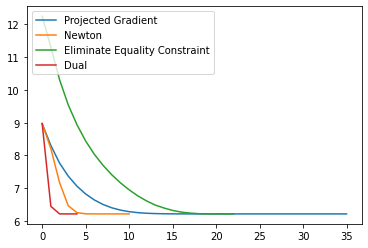

In [20]:
plt.plot(time1, values1)
plt.plot(time2, values2)
plt.plot(time3, values3)
plt.plot(time4, values4)
plt.legend(['Projected Gradient', 'Newton', 'Eliminate Equality Constraint', 'Dual'], loc='upper left')
plt.savefig('result.png')
plt.show()